In [1]:
#hide
from fastbook import *
from kaggle import api
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
#pd.options.display.max_columns = 8
#plt.style.use('dark_background')
import subprocess

In [2]:
!cat /home/xar/.kaggle/kaggle.json

{"username":"maxmattson","key":"d6fd54bc427921f2a2b17374d2321dc4"}

In [3]:
creds = '{"username":"maxmattson","key":"d6fd54bc427921f2a2b17374d2321dc4"}'

In [4]:
credPath = Path('/home/xar/.kaggle/kaggle.json').expanduser()
credPath

Path('/home/xar/.kaggle/kaggle.json')

In [5]:
path = URLs.path('bikeshare')
path = Path('/media/xar/barracuda1/fast.ai/data/bikeshare')
path

Path('/media/xar/barracuda1/fast.ai/data/bikeshare')

In [6]:
if not path.exists():
    path.mkdir(parents=True)
    api.competition_download_cli('bike-sharing-demand', path=path)
    file_extract(path/'bike-sharing-demand.zip')
    
path.ls(file_type='text')

(#3) [Path('/media/xar/barracuda1/fast.ai/data/bikeshare/test.csv'),Path('/media/xar/barracuda1/fast.ai/data/bikeshare/sampleSubmission.csv'),Path('/media/xar/barracuda1/fast.ai/data/bikeshare/train.csv')]

### Look at the data

In [7]:
df = pd.read_csv(path/'train.csv', low_memory=False)

In [8]:
df.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')

#### Handle ordinal columns (non-numeric)

In [9]:
for col in df.columns:
    print(col,':', df[col].unique())

datetime : ['2011-01-01 00:00:00' '2011-01-01 01:00:00' '2011-01-01 02:00:00' ... '2012-12-19 21:00:00' '2012-12-19 22:00:00' '2012-12-19 23:00:00']
season : [1 2 3 4]
holiday : [0 1]
workingday : [0 1]
weather : [1 2 3 4]
temp : [ 9.84  9.02  8.2  13.12 15.58 14.76 17.22 18.86 18.04 16.4  13.94 12.3  10.66  6.56  5.74  7.38  4.92 11.48  4.1   3.28  2.46 21.32 22.96 23.78 24.6  19.68 22.14 20.5  27.06 26.24 25.42 27.88 28.7
 30.34 31.16 29.52 33.62 35.26 36.9  32.8  31.98 34.44 36.08 37.72 38.54  1.64  0.82 39.36 41.  ]
atemp : [14.395 13.635 12.88  17.425 19.695 16.665 21.21  22.725 21.97  20.455 11.365 10.605  9.85   8.335  6.82   5.305  6.06   9.09  12.12   7.575 15.91   3.03   3.79   4.545 15.15  18.18  25.    26.515
 27.275 29.545 23.485 25.76  31.06  30.305 24.24  18.94  31.82  32.575 33.335 28.79  34.85  35.605 37.12  40.15  41.665 40.91  39.395 34.09  28.03  36.365 37.88  42.425 43.94  38.635  1.515  0.76
  2.275 43.18  44.695 45.455]
humidity : [ 81  80  75  86  76  77  72  82

In [10]:
depVar = 'count'

In [11]:
df[depVar] = np.log(df[depVar])

### Handle dates

In [12]:
df = add_datepart(df, 'datetime')

In [13]:
dfTest = pd.read_csv(path/'test.csv', low_memory=False)
dfTest = add_datepart(dfTest, 'datetime')

In [14]:
' '.join(o for o in df.columns if o.startswith('datetime'))

'datetimeYear datetimeMonth datetimeWeek datetimeDay datetimeDayofweek datetimeDayofyear datetimeIs_month_end datetimeIs_month_start datetimeIs_quarter_end datetimeIs_quarter_start datetimeIs_year_end datetimeIs_year_start datetimeElapsed'

### Using TabularPandas and TabularProc

In [15]:
df.columns

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'casual', 'registered', 'count',
       'datetimeYear', 'datetimeMonth', 'datetimeWeek', 'datetimeDay',
       'datetimeDayofweek', 'datetimeDayofyear', 'datetimeIs_month_end',
       'datetimeIs_month_start', 'datetimeIs_quarter_end',
       'datetimeIs_quarter_start', 'datetimeIs_year_end',
       'datetimeIs_year_start', 'datetimeElapsed'],
      dtype='object')

In [16]:
for col in df.columns:
    print(col, ':', df[col].unique())

season : [1 2 3 4]
holiday : [0 1]
workingday : [0 1]
weather : [1 2 3 4]
temp : [ 9.84  9.02  8.2  13.12 15.58 14.76 17.22 18.86 18.04 16.4  13.94 12.3  10.66  6.56  5.74  7.38  4.92 11.48  4.1   3.28  2.46 21.32 22.96 23.78 24.6  19.68 22.14 20.5  27.06 26.24 25.42 27.88 28.7
 30.34 31.16 29.52 33.62 35.26 36.9  32.8  31.98 34.44 36.08 37.72 38.54  1.64  0.82 39.36 41.  ]
atemp : [14.395 13.635 12.88  17.425 19.695 16.665 21.21  22.725 21.97  20.455 11.365 10.605  9.85   8.335  6.82   5.305  6.06   9.09  12.12   7.575 15.91   3.03   3.79   4.545 15.15  18.18  25.    26.515
 27.275 29.545 23.485 25.76  31.06  30.305 24.24  18.94  31.82  32.575 33.335 28.79  34.85  35.605 37.12  40.15  41.665 40.91  39.395 34.09  28.03  36.365 37.88  42.425 43.94  38.635  1.515  0.76
  2.275 43.18  44.695 45.455]
humidity : [ 81  80  75  86  76  77  72  82  88  87  94 100  71  66  57  46  42  39  44  47  50  43  40  35  30  32  64  69  55  59  63  68  74  51  56  52  49  48  37  33  28  38  36  93  29 

In [17]:
procs = [Categorify, FillMissing]

I'm going to try making the validation set the last 4 days of each month in the training set, i.e. 18th--19th of each month.

In [29]:
cond = (df.datetimeDay>=18)
trainIdx = np.where(~cond)[0]
validIdx = np.where( cond)[0]

splits = (list(trainIdx), list(validIdx))

In [30]:
cont,cat = cont_cat_split(df, max_card=18, dep_var=depVar)
cont, cat

(['temp',
  'atemp',
  'humidity',
  'windspeed',
  'casual',
  'registered',
  'datetimeWeek',
  'datetimeDay',
  'datetimeDayofyear',
  'datetimeElapsed'],
 ['season',
  'holiday',
  'workingday',
  'weather',
  'datetimeYear',
  'datetimeMonth',
  'datetimeDayofweek',
  'datetimeIs_month_end',
  'datetimeIs_month_start',
  'datetimeIs_quarter_end',
  'datetimeIs_quarter_start',
  'datetimeIs_year_end',
  'datetimeIs_year_start'])

In [31]:
to = TabularPandas(df, 
                   procs=procs, 
                   cat_names=cat, 
                   cont_names=cont, 
                   y_names=depVar, 
                   splits=splits)

In [32]:
len(to.train), len(to.valid)

(9749, 1137)

In [33]:
to.show(5)

,season,holiday,workingday,weather,datetimeYear,datetimeMonth,datetimeDayofweek,datetimeIs_month_end,datetimeIs_month_start,datetimeIs_quarter_end,datetimeIs_quarter_start,datetimeIs_year_end,datetimeIs_year_start,temp,atemp,humidity,windspeed,casual,registered,datetimeWeek,datetimeDay,datetimeDayofyear,datetimeElapsed,count
0,1,0,0,1,2011,1,5,False,True,False,True,False,True,9.84,14.395,81,0.0,3,13,52,1,1,1.293840e+09,2.772589
1,1,0,0,1,2011,1,5,False,True,False,True,False,True,9.02,13.635,80,0.0,8,32,52,1,1,1.293844e+09,3.688879
2,1,0,0,1,2011,1,5,False,True,False,True,False,True,9.02,13.635,80,0.0,5,27,52,1,1,1.293847e+09,3.465736
3,1,0,0,1,2011,1,5,False,True,False,True,False,True,9.84,14.395,75,0.0,3,10,52,1,1,1.293851e+09,2.564949
4,1,0,0,1,2011,1,5,False,True,False,True,False,True,9.84,14.395,75,0.0,0,1,52,1,1,1.293854e+09,0.000000


In [34]:
to.items.head(5)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,datetimeYear,datetimeMonth,datetimeWeek,datetimeDay,datetimeDayofweek,datetimeDayofyear,datetimeIs_month_end,datetimeIs_month_start,datetimeIs_quarter_end,datetimeIs_quarter_start,datetimeIs_year_end,datetimeIs_year_start,datetimeElapsed
0,1,1,1,1,9.84,14.395,81,0.0,3,13,2.772589,1,1,52,1,6,1,1,2,1,2,1,2,1.293840e+09
1,1,1,1,1,9.02,13.635,80,0.0,8,32,3.688879,1,1,52,1,6,1,1,2,1,2,1,2,1.293844e+09
2,1,1,1,1,9.02,13.635,80,0.0,5,27,3.465736,1,1,52,1,6,1,1,2,1,2,1,2,1.293847e+09
3,1,1,1,1,9.84,14.395,75,0.0,3,10,2.564949,1,1,52,1,6,1,1,2,1,2,1,2,1.293851e+09
4,1,1,1,1,9.84,14.395,75,0.0,0,1,0.000000,1,1,52,1,6,1,1,2,1,2,1,2,1.293854e+09


In [35]:
save_pickle(path/'to.pkl',to)

### Creating the Decision Tree

In [36]:
to = load_pickle(path/'to.pkl')

In [37]:
xs,y = to.train.xs, to.train.y
validXs,validY = to.valid.xs, to.valid.y

In [38]:
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs, y)

DecisionTreeRegressor(max_leaf_nodes=4)

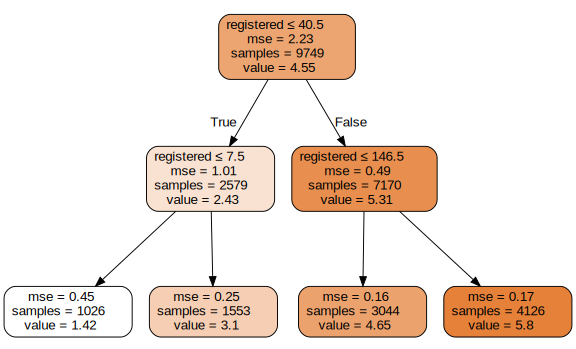

In [39]:
draw_tree(m, xs, size=8, leaves_parallel=True, precision=2)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


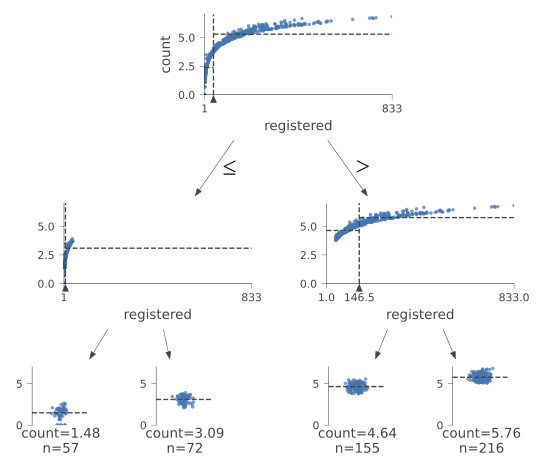

In [46]:
sampIdx = np.random.permutation(len(y))[:500]
dtreeviz(m, xs.iloc[sampIdx], y.iloc[sampIdx], xs.columns, depVar,
         scale=1.8, label_fontsize=10, orientation='TB')

Now build bigger tree algorithm, so don't pass in `max_leaf_nodes`,

In [47]:
m = DecisionTreeRegressor()
m.fit(xs, y)

DecisionTreeRegressor()

In [48]:
def r_mse(pred, y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [49]:
m_rmse(m, xs, y)

0.0

Check valid to see if model is overfitting, which it obviously is,

In [50]:
m_rmse(m, validXs, validY)

0.039673

So we are overfitting, because we have nearly as many leaf nodes as data points,

In [51]:
m.get_n_leaves(), len(xs)

(5435, 9749)

Change stopping rule to have more data points in each leaf node,

In [66]:
m = DecisionTreeRegressor(min_samples_leaf=20)
m.fit(to.train.xs, to.train.y)
m_rmse(m, xs, y), m_rmse(m, validXs, validY)

(0.046197, 0.077197)

In [67]:
m.get_n_leaves()

357

### Creating a Random Forest

In [73]:
def rf(xs, y, n_estimators=40, max_samples=5_000, max_features=0.5,
       min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
                                 max_samples=max_samples, max_features=max_features,
                                 min_samples_leaf=min_samples_leaf,
                                 oob_score=True).fit(xs, y)

In [74]:
m = rf(xs, y)

In [76]:
m_rmse(m, xs, y), m_rmse(m, validXs, validY)

(0.044105, 0.059183)

Get the predictions from each individual tree in our forest, which are in the `n_estimators_` attribute, 

In [78]:
preds = np.stack([t.predict(validXs) for t in m.estimators_])
r_mse(preds.mean(0), validY) # mean is the same as whole forest above

0.059183

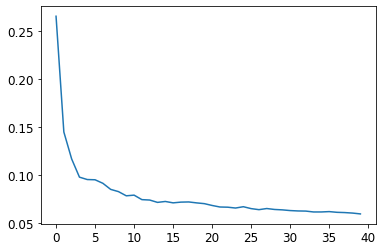

In [85]:
plt.plot([r_mse(preds[:i+1].mean(0), validY) for i in range(len(preds))]);